In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Prep behavioral data

#### Get anymaze data

In [2]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/TM_1s.csv'

data = pd.read_csv(path)
data = pd.DataFrame(data = data)
print(data.shape)
data.head()

(3610, 14)


,Test,Animal,Trial,Time,Segment of test,Start : entries,T : entries,EE (neutral) : entries,EM (neutral) : entries,EW (neutral) : entries,Center : entries,WW (odor) : entries,WM (odor) : entries,WE (odor) : entries
0,1,1,1,9:55,0 - 1 secs.,0,1,0,0,0,0,0,0,0
1,1,1,1,9:55,1 - 2 secs.,0,0,0,0,0,0,0,0,0
2,1,1,1,9:55,2 - 3 secs.,1,0,0,0,0,0,0,0,0
3,1,1,1,9:55,3 - 4 secs.,0,0,0,0,0,0,0,0,0
4,1,1,1,9:55,4 - 5 secs.,0,0,0,0,0,0,0,0,0


In [3]:
data['time_running'] = [int(x.split(' ')[0]) for x in data['Segment of test']]
#data.rename(columns={'Time': 'time_start'}, inplace=True)
print(data.shape)

data_entries = pd.melt(data, id_vars=['Test', 'time_running'], 
        value_vars=['Start : entries', 'T : entries', 'EE (neutral) : entries', 
                    'EM (neutral) : entries', 'EW (neutral) : entries', 'Center : entries', 
                    'WW (odor) : entries', 'WM (odor) : entries', 'WE (odor) : entries'],
        var_name='entry_location', value_name='entry_count')

print(data_entries.shape)
data_entries = data_entries[data_entries['entry_count'] != 0]

#strip off entries
data_entries['entry_location'] = [x.split(' ')[0] for x in data_entries['entry_location']]

print(data_entries.shape)
data_entries.sort_values(['Test', 'time_running']).head()

(3610, 15)
(32490, 4)
(1612, 4)


,Test,time_running,entry_location,entry_count
3610,1,0,T,1
2,1,2,Start,1
3615,1,5,T,1
18059,1,9,Center,1
25280,1,10,WM,1


In [4]:
def location_switch(df):
    
    entries_array = []
    time_array = []
    prev_location = 'start'
    prev_time = 0
    for index, row in df.iterrows():
    
        #get current location and time
        current_location = row['entry_location']
        current_time = row['time_running']
    
        #make string of prev and current locations
        location_switch = str(prev_location + '_' + current_location)
        #get time difference
        time_diff = current_time - prev_time
    
        #add to array
        entries_array.append(location_switch)
        time_array.append(time_diff)
    
        #update prev_location
        prev_location = current_location
        prev_time = current_time

    df['location_switch'] = entries_array
    df['switch_time'] = time_array
    
    return df

In [5]:
data_entries = data_entries.sort_values(['Test', 'time_running'])

data_location_switch = pd.DataFrame()

for test in data_entries['Test'].unique():
    print(data_location_switch.shape)
    print(test)
    data_int = data_entries[data_entries['Test'] == test]
    data_int = data_int.sort_values(['Test', 'time_running'])
    #use location_switch function 
    data_int = location_switch(data_int)
    
    if data_location_switch.shape[0] == 0:
        data_location_switch = data_int
    else:
        data_location_switch = pd.concat([data_location_switch, data_int], axis=0)    
        
print(data_location_switch.shape)
data_location_switch.head()

(0, 0)
1
(169, 6)
2
(311, 6)
3
(449, 6)
4
(627, 6)
5
(768, 6)
6
(917, 6)
7
(1063, 6)
8
(1153, 6)
9
(1298, 6)
10
(1404, 6)
11
(1508, 6)
12
(1612, 6)


,Test,time_running,entry_location,entry_count,location_switch,switch_time
3610,1,0,T,1,start_T,0
2,1,2,Start,1,T_Start,2
3615,1,5,T,1,Start_T,3
18059,1,9,Center,1,T_Center,4
25280,1,10,WM,1,Center_WM,1


#### Combine with meta

In [6]:
path_meta = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/TM_5m.csv'

data = pd.read_csv(path_meta)
data = pd.DataFrame(data = data)
print(data.shape)
data.head()

(12, 16)


,Animal,Group,Time_FP,Time_AM,Test,Animal.1,Trial,Time,Distance,Mean speed,Start : time,T : time,EE (neutral) : time,EE (neutral) : latency to first entry,WW (odor) : time,WW (odor) : latency to first entry
0,1155,2,9:48:40,9:55:34,1,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8
1,1160,2,10:03:36,10:06:09,2,2,1,10:06,17.154,0.056,56.5,48.1,19.2,20.6,24.5,12.0
2,1153,1,10:14:32,10:17:53,3,3,1,10:17,14.787,0.048,71.8,34.6,32.1,24.8,58.0,17.4
3,1159,2,10:25:27,10:28:16,4,4,1,10:28,22.462,0.074,54.1,44.4,26.4,18.3,14.4,12.7
4,1154,1,10:36:03,10:38:29,5,5,1,10:38,17.450,0.057,54.3,59.6,21.3,14.5,24.2,20.0


In [7]:
#get time diff in seconds
data['diff_seconds'] = pd.to_datetime(data['Time_AM']) - pd.to_datetime(data['Time_FP'])
data['diff_seconds']=data['diff_seconds']/np.timedelta64(1,'s')
data.head()

,Animal,Group,Time_FP,Time_AM,Test,Animal.1,Trial,Time,Distance,Mean speed,Start : time,T : time,EE (neutral) : time,EE (neutral) : latency to first entry,WW (odor) : time,WW (odor) : latency to first entry,diff_seconds
0,1155,2,9:48:40,9:55:34,1,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0
1,1160,2,10:03:36,10:06:09,2,2,1,10:06,17.154,0.056,56.5,48.1,19.2,20.6,24.5,12.0,153.0
2,1153,1,10:14:32,10:17:53,3,3,1,10:17,14.787,0.048,71.8,34.6,32.1,24.8,58.0,17.4,201.0
3,1159,2,10:25:27,10:28:16,4,4,1,10:28,22.462,0.074,54.1,44.4,26.4,18.3,14.4,12.7,169.0
4,1154,1,10:36:03,10:38:29,5,5,1,10:38,17.450,0.057,54.3,59.6,21.3,14.5,24.2,20.0,146.0


In [8]:
data_am_final = data_location_switch.merge(data, on='Test')
data_am_final['time_correct'] = data_am_final['time_running'] + data_am_final['diff_seconds']
data_am_final.head()

,Test,time_running,entry_location,entry_count,location_switch,switch_time,Animal,Group,Time_FP,Time_AM,Animal.1,Trial,Time,Distance,Mean speed,Start : time,T : time,EE (neutral) : time,EE (neutral) : latency to first entry,WW (odor) : time,WW (odor) : latency to first entry,diff_seconds,time_correct
0,1,0,T,1,start_T,0,1155,2,9:48:40,9:55:34,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0,414.0
1,1,2,Start,1,T_Start,2,1155,2,9:48:40,9:55:34,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0,416.0
2,1,5,T,1,Start_T,3,1155,2,9:48:40,9:55:34,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0,419.0
3,1,9,Center,1,T_Center,4,1155,2,9:48:40,9:55:34,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0,423.0
4,1,10,WM,1,Center_WM,1,1155,2,9:48:40,9:55:34,1,1,9:55,19.883,0.065,57.2,65.6,21.0,18.3,8.5,11.8,414.0,424.0


### Prep fiber photometry data

In [9]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129'

dir_path_list = os.listdir(orig_path)

data_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    data_dir_paths.append(int_path)
    
data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1163_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1155_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1159_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1161_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1157_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1153_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1165_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1154_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1158_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1162_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1160_TM.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1166_TM.txt']

In [10]:
data_FP = pd.DataFrame()

for path in data_dir_paths:
    print(data_FP.shape)
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    data_FP_int = pd.DataFrame()
    animal = int(path.split('/')[-1].split('_')[0])
    task = path.split('/')[-1].split('_')[1].split('.')[0]
    
    with open(path, 'r') as file:
        lns = file.readlines()
    
    for ln in lns:
        #print(ln)

        time = float(ln.split('\t')[0])
        signal = float(ln.split('\t')[1])  
        d = {'Animal': animal, 'task': task, 'time': [time], 'signal': [signal]}
        data_FP_int_int = pd.DataFrame(data=d)
        
        if data_FP_int.shape[0] == 0:
            data_FP_int = data_FP_int_int
        else:
            data_FP_int = pd.concat([data_FP_int, data_FP_int_int], axis=0)
        
    if data_FP.shape[0] == 0:
        data_FP = data_FP_int
    else:
        data_FP = pd.concat([data_FP, data_FP_int], axis=0)        

print(data_FP.shape)
data_FP.tail()

(0, 0)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1163_TM.txt
(68096, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1155_TM.txt
(140269, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1159_TM.txt
(189925, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1161_TM.txt
(236628, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1157_TM.txt
(287915, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1153_TM.txt
(336665, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1165_TM.txt
(379681, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1154_TM.txt
(426243, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1158_TM.txt
(470541, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1162_TM.txt
(517767, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/210129/1160_TM.txt
(565912, 4)
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/21012

,Animal,task,time,signal
0,1166,TM,487.82,64244.0
0,1166,TM,487.83,64244.0
0,1166,TM,487.84,64241.0
0,1166,TM,487.85,64241.0
0,1166,TM,487.86,64239.0


In [11]:
#create seconds
data_FP['time_correct'] = [int((str(x)).split('.')[0]) for x in data_FP['time']]
#groupby seconds to reduce the data
data_FP_secs = data_FP.groupby(['Animal', 'task', 'time_correct']).mean().reset_index()
#data_FP_secs = data_FP_secs[data_FP_secs['signal'] < 40000]
print(data_FP_secs.shape)
data_FP_secs.head()

(6152, 5)


,Animal,task,time_correct,time,signal
0,1153,TM,0,0.495,59061.02
1,1153,TM,1,1.495,64072.17
2,1153,TM,2,2.495,64073.61
3,1153,TM,3,3.495,64072.66
4,1153,TM,4,4.495,64073.29


In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x='time_correct', y='signal', data=data_FP_secs)

### Combine data streams

In [50]:
data_final = data_FP_secs.merge(data_am_final, on=['Animal', 'time_correct'], how='left')
print(data_final.shape)
data_final.head()

(6385, 26)


,Animal,task,time_correct,time,signal,Test,time_running,entry_location,entry_count,location_switch,switch_time,Group,Time_FP,Time_AM,Animal.1,Trial,Time,Distance,Mean speed,Start : time,T : time,EE (neutral) : time,EE (neutral) : latency to first entry,WW (odor) : time,WW (odor) : latency to first entry,diff_seconds
0,1153,TM,0,0.495,59061.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1153,TM,1,1.495,64072.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1153,TM,2,2.495,64073.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1153,TM,3,3.495,64072.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1153,TM,4,4.495,64073.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### transformed into df/f using a rolling average of 1-min around each data point as f, and normalizing each data point fn with the formula (fn-f)/f.

### In Pavlovian conditioning, ΔF/F time-series signal is further normalized using robust Z-score (subtraction of median and division by median absolute deviation, calculated from the entire session) to account for potential differences in signal variance across animals and sessions.

### Next, the demodulated signal was transformed into df/f using a rolling average of 1-min around each data point as f, and normalizing each data point fn with the formula (fn-f)/f. Photometry signals were exported as average peri-event time histograms around these events, and specific behavioral periods were extracted for analysis. These periods were: baseline (a 5 s period beginning 15 s before the entry into the zone), pre-movement (a 5 s period beginning 8 s before the entry into the zone) and movement (a 1 s period beginning at the peak of the movement). 

Embedded Image

In [134]:
def peri_event(df, time, total_time, baseline_time):
    
    #index = df index when location switch happens
    #total_time = total length of peri event
    #baseline_time = baseline duration (assumed that this should be taken from immediately prior to the switch)
    
    start_time = time - baseline_time
    end_time = time - baseline_time + total_time
    
    #get baseline signal and compute mean and MAD
    baseline_signal = df[(df['time_correct'] >= start_time) & (df['time_correct'] <= (time-1))]['signal']
    f_mean = baseline_signal.mean()
    
    #get peri event signal
    data_int = df[(df['time_correct'] >= start_time) & (df['time_correct'] <= (end_time))]
    
    #compute signal delta f over f using a baseline duration 
    data_int['sig_norm'] = (data_int['signal'] - f_mean) / f_mean
    
    #compute median of baseline delta f over f
    baseline_deltaf = data_int[(data_int['time_correct'] >= start_time) & (data_int['time_correct'] <= (time-1))]['sig_norm']
    f_med = baseline_deltaf.median()
    f_mad = baseline_deltaf.mad()

    #compute robust z score 
    data_int['sig_norm_z'] = (data_int['sig_norm'] - f_med) / (f_mad)
    
    return data_int

In [182]:
def robustz_df(df):
    
    times = df[~df['location_switch'].isna()]['time_correct'].values

    data_final_int = pd.DataFrame()

    for time in times:
        data_int = peri_event(df, time, 15, 5)
        data_int['event'] = data_int.iloc[5]['location_switch']
        data_int['event_time'] = np.arange(0, data_int.shape[0])
    
        if data_final_int.shape[0] == 0:
            data_final_int = data_int
        else:
            data_final_int = pd.concat([data_final_int, data_int], axis=0)

    return data_final_int

In [187]:
animal = data_final['Animal'].unique()[2]
df = data_final[data_final['Animal'] == animal]
#times = df[~df['location_switch'].isna()]['time_correct'].values
#data_int = peri_event(df, times[2], total_time, baseline_time)
data_final_int = robustz_df(df)
data_final_int.head()

,Animal,task,time_correct,time,signal,Test,time_running,entry_location,entry_count,location_switch,switch_time,Group,Time_FP,Time_AM,Animal.1,Trial,Time,Distance,Mean speed,Start : time,T : time,EE (neutral) : time,EE (neutral) : latency to first entry,WW (odor) : time,WW (odor) : latency to first entry,diff_seconds,sig_norm,sig_norm_z,event,event_time
1409,1155,TM,409,409.495,63976.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.193747,start_T,0
1410,1155,TM,410,410.495,63976.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000014,0.000000,start_T,1
1411,1155,TM,411,411.495,63977.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000027,0.554516,start_T,2
1412,1155,TM,412,412.495,63974.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000019,-1.396312,start_T,3
1413,1155,TM,413,413.495,63972.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000039,-2.271513,start_T,4


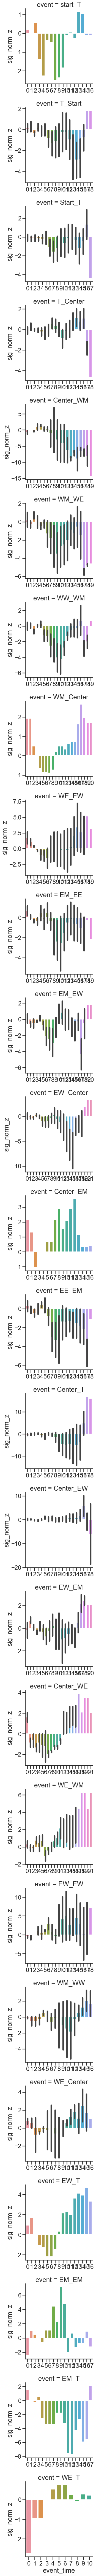

In [188]:
sns.catplot(x='event_time', y='sig_norm_z', data=data_final_int, 
            col='event', col_wrap=1, kind='bar',
           sharey=False, sharex=False, ci=68, height=5, aspect=1)

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x='time_correct', y='sig_norm', data=data_int)